# BP Neural Networks

Data：<br/>
有5000个训练样本，每个样本是20*20像素的数字的灰度图像。每个像素代表一个浮点数，表示该位置的灰度强度。20×20的像素网格被展开成一个400维的
向量。在我们的数据矩阵X中，每一个样本都变成了一行，这给了我们一个5000×400矩阵X，每一行都是一个手写数字图像的训练样本。

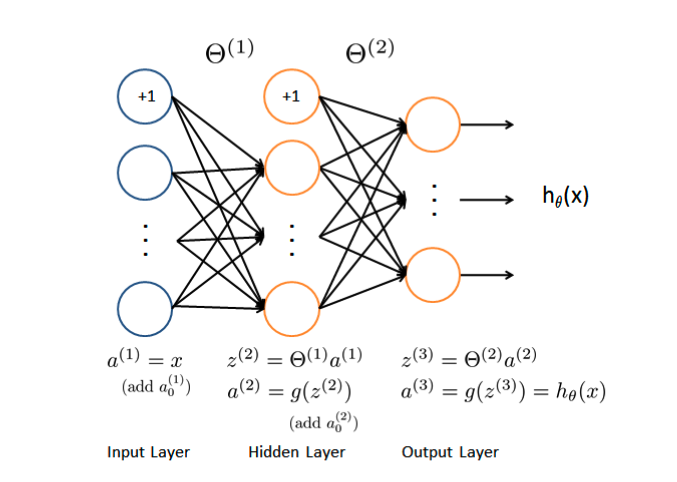

The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [5]:
#输出多个output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

### 数据预处理

In [7]:
data = loadmat("data.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [8]:
raw_X = data["X"]
raw_y = data["y"]

In [9]:
type(raw_X),type(raw_y)
raw_X.shape,raw_y.shape
print(np.unique(raw_y))

(numpy.ndarray, numpy.ndarray)

((5000, 400), (5000, 1))

[ 1  2  3  4  5  6  7  8  9 10]


从结果可以看出，为了方便计算，将0设置成了第10类

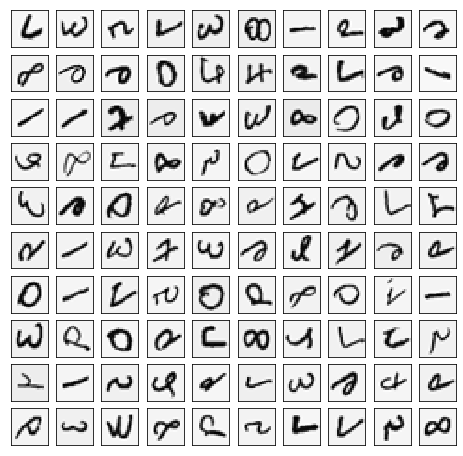

In [10]:
def plot_100_image(X): #随机打印100个手写体
    index = np.random.choice(np.arange(X.shape[0]),100)
    images = X[index,:]
    fig, ax = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    for i in range(10):
        for j in range(10):
            ax[i,j].matshow(images[10*i+j].reshape(20,20),cmap="gray_r")
            plt.xticks([])
            plt.yticks([])
plot_100_image(raw_X)

### 变量初始化

In [11]:
X = np.insert(raw_X,0,1,axis=1) #在X的index为0的地方按列（axis=1）插入一列1
X.shape

(5000, 401)

In [12]:
def matrix(y):
    mat_y = []
    K = len(np.unique(raw_y))#K类
    for i in y:
        vect_y = np.zeros(K)
        vect_y[i-1] = 1
        mat_y.append(vect_y)
    return np.array(mat_y)
y = matrix(raw_y)

In [13]:
X.shape 
y.shape

(5000, 401)

(5000, 10)

Random Initialization

In [14]:
#范围为-0.3～0.3,一共生成row*col个元素
def random_initial(row,col):
    return np.array(np.random.uniform(-0.3,0.3,row*col)).reshape(row,col)
Theta1 = random_initial(25,401)
Theta2 = random_initial(10,26)

In [15]:
Theta1.shape
Theta2.shape

(25, 401)

(10, 26)

### Unroll and roll parameters

In [16]:
def unroll(a,b):
    return np.r_[a.flatten(),b.flatten()]

In [17]:
theta = unroll(Theta1,Theta2) #25*401+10*26=10285
theta.shape

(10285,)

In [18]:
def roll(seq):
    return seq[0:25*401].reshape(25,401),seq[25*401:].reshape(10,26)

### Forward propagation

In [19]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

In [20]:
def forward(theta,X):
    Theta1,Theta2 = roll(theta)
    a1 = X                                     #(5000x401)
    z2 = np.dot(a1,Theta1.T)                   #(5000x25)
    a2 = np.insert(sigmoid(z2),0,1,axis=1)     #(5000x26)
    z3 = np.dot(a2,Theta2.T)                   #(5000x10)
    a3 = sigmoid(z3)                           #(5000x10)
    return a1,z2,a2,z3,a3

### Regularized cost function

In [21]:
def regularized_cost(theta,X,y,lamda):
    Theta1,Theta2 = roll(theta)
    a1,z2,a2,z3,h = forward(theta,X)
    Part1 = np.sum(-y*np.log(h)-(1-y)*np.log(1-h))/len(X) #   *表示array对应元素相乘
    Part2 = np.sum(np.power(Theta1[:,1:],2))+np.sum(np.power(Theta2[:,1:],2))#第一列为theta0,不penalize
    return Part1 + lamda/(2*len(X))*Part2

In [22]:
regularized_cost(theta,X,y,2)

7.654113678817654

### Back propagation

In [23]:
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [24]:
#D2应该和Theta2有着同样的维度，D1应该和Theta1有着同样的维度
def regularized_gradient(theta,X,y,lamda):
    Theta1,Theta2 = roll(theta)
    a1,z2,a2,z3,a3 = forward(theta,X)
    delta3 = a3 - y      #(5000x10)
    delta2 = np.dot(delta3,Theta2[:,1:]) * sigmoid_gradient(z2)    #(5000x25)
    D2 = delta3.T @ a2 # @ array 矩阵乘法  (10x26)
    D1 = delta2.T @ a1 # (25x401)
    Theta1[:,0] = 0
    Theta2[:,0] = 0
    reg_D1 = (1/len(X))*(D1 + lamda*Theta1)
    reg_D2 = (1/len(X))*(D2 + lamda*Theta2)
    reg_D = unroll(reg_D1,reg_D2)
    return reg_D

In [25]:
regularized_gradient(theta,X,y,2).shape

(10285,)

### Gradient checking

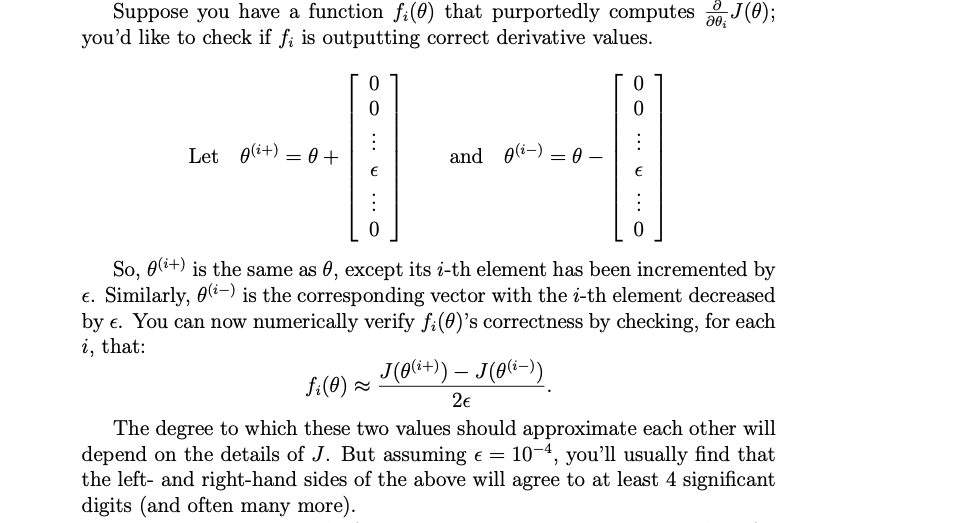

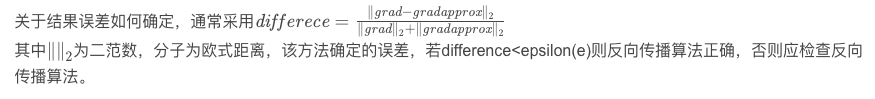

In [26]:
def gradient_checking(theta,X,y,e):
    def a_numeric_grad(plus,minus):
        return (regularized_cost(plus,X,y,1)-regularized_cost(minus,X,y,1))/(2*e) #取lamda=1
    numeric_grad = []
    for i in range(len(theta)):
        plus = theta.copy()
        minus = theta.copy()
        plus[i] = plus[i] + e
        minus[i] = minus[i] - e
        numeric_grad_i = a_numeric_grad(plus,minus)
        numeric_grad.append(numeric_grad_i)
    numeric_grad = np.array(numeric_grad)
    Delta_grad = regularized_gradient(theta,X,y,1)
    diff = np.linalg.norm(numeric_grad-Delta_grad)/np.linalg.norm(numeric_grad+Delta_grad)#np.linalg.norm求范数
    print(''''If your backpropagation implementation is correct,\n
          the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
          \nRelative Difference: {}\n'''.format(diff))

Note:函数名和变量名不能相同

In [28]:
gradient_checking(theta,X,y,0.0001)

'If your backpropagation implementation is correct,

          the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
          
Relative Difference: 1.0197937385790276e-10



Great!

### Learning parameters

In [29]:
result = opt.minimize(fun=regularized_cost,x0=theta,args=(X,y,1),method="TNC",
                      jac=regularized_gradient,options={"maxiter":400})
#options={"maxiter":400} Maximum number of iterations to perform.

In [30]:
theta = result["x"]

In [31]:
from sklearn.metrics import classification_report  # 这个包是评价报告
def accuracy(theta, X, y):
    _, _, _, _, h = forward(theta, X)
    y_pred = np.argmax(h, axis=1) + 1
    print(classification_report(y, y_pred))

In [32]:
accuracy(theta,X,raw_y)

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       500
           2       1.00      0.99      0.99       500
           3       1.00      0.99      0.99       500
           4       1.00      0.99      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      1.00      1.00       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       0.99      1.00      1.00       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



因为每次初始化的theta不同，且不是一个凸规划，所以执行时间和结果会有差异，但差异不大

### Visualizing the hidden layer

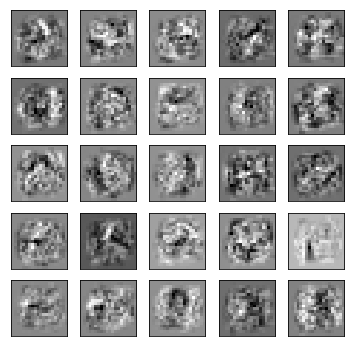

In [33]:
def plot_hidden(theta):
    Theta1, _ = roll(theta)
    Theta1 = Theta1[:, 1:]
    fig,ax_array = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(6,6))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(Theta1[r * 5 + c].reshape(20, 20), cmap='gray_r')
            plt.xticks([])
            plt.yticks([])
    plt.show()
plot_hidden(theta)